In [1]:
import torch
import sys
import flash_attn

print("Py available:", sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CuDNN version PyTorch uses:", torch.backends.cudnn.version())
print(f"Flash Attention version: {flash_attn.__version__}")

print(torch.zeros(1).cuda())


Py available: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:46:25) [GCC 14.3.0]
PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
cuDNN version: 91002
Flash Attention version: 2.7.3
tensor([0.], device='cuda:0')


In [16]:
# !sed -i '/flash-attn/d' requirements.txt
# !sed -i 's/cchardet/faust-cchardet/g' requirements.txt
# !sed -i 's/opencv-python/opencv-python-headless/g' requirements.txt
# !pip install -r requirements.txt
# !pip install -r requirements_demo.txt

# it seems that some packages are too old
# !pip install --upgrade accelerate peft transformers
# !pip install "numpy<2"

# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu118
# !pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.3/flash_attn-2.7.3+cu11torch2.6cxx11abiFALSE-cp311-cp311-linux_x86_64.whl
# !pip list

# !pip cache purge

!pip freeze > requirements.txt

In [ ]:
# install checkpoints
# !wget https://twg.kakaocdn.net/brainrepo/models/honeybee/7B-C-Abs-M144_PT.tar.gz
# ! mkdir checkpoints
# !tar -xvzf checkpoints/7B-C-Abs-M256.tar.gz -C checkpoints

7B-C-Abs-M256/
7B-C-Abs-M256/last/
7B-C-Abs-M256/last/config.json
7B-C-Abs-M256/last/pytorch_model.bin


In [2]:
%matplotlib inline
import flash_attn
import torch
import matplotlib.pyplot as plt
from PIL import Image

from pipeline.interface import get_model

In [3]:
def construct_input_prompt(user_prompt):
    SYSTEM_MESSAGE = "The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.\n"
    IMAGE_TOKEN = "Human: <image>\n" #<image> denotes an image placeholder.
    USER_PROMPT = f"Human: {user_prompt}\n"

    return SYSTEM_MESSAGE + IMAGE_TOKEN + USER_PROMPT + "AI: "

In [ ]:
import torch
import torch.nn as nn
from honeybee.projectors.projectors import Projector

def robust_load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
    """
    Patched loader that dynamically fixes 'pos_emb' shape mismatches
    regardless of the specific dictionary key name.
    """
    keys_to_fix = []
    
    # scan the state_dict for the problematic tensor
    for k, v in state_dict.items():
        # Check if key contains 'pos_emb' and has the legacy shape (257)
        if "pos_emb" in k and v.shape == (1, 257, 1024):
             if hasattr(self, 'pos_emb') and self.pos_emb.shape == (1, 256, 1024):
                keys_to_fix.append(k)
    
    # Fix the identified keys
    for k in keys_to_fix:
        print(f"Running Patch: Resizing '{k}' from 257 to 256 (removing obsolete CLS token)")
        # Slice the tensor to remove the first token
        state_dict[k] = state_dict[k][:, 1:]

    # Call the standard PyTorch loader (bypassing the broken Honeybee implementation)
    nn.Module._load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs)

# Apply the new robust patch
Projector._load_from_state_dict = robust_load_from_state_dict
print("Robust patch applied successfully.")

Patch applied to Projector._load_from_state_dict
Robust patch applied successfully.


In [5]:
# Load trained model
ckpt_path = "checkpoints/7B-C-Abs-M144_PT/last/"
model, tokenizer, processor = get_model(ckpt_path, use_bf16=True)
model.cuda()
print("Model initialization is done.")

INFO 01/22 18:46:28 | Build vision model ...
INFO 01/22 18:46:28 | Build projector ...
INFO 01/22 18:46:28 | Build LM ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


Running Patch: Resizing 'pos_emb' from 257 to 256 (removing obsolete CLS token)


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


Model initialization is done.


In [7]:
prompts = [construct_input_prompt("Explain why this meme is funny.")]
image_list = ["./examples/monday.jpg"]

In [8]:
images = [Image.open(_) for _ in image_list]
inputs = processor(texts=prompts, images=images)
inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
inputs = {k: v.to(model.device) for k, v in inputs.items()}

In [9]:
# generate kwargs (the same in transformers) can be passed in the do_generate()
generate_kwargs = {
    'do_sample': True,
    'top_k': 5,
    'max_length': 512
}

In [10]:
# IMPORTANT: This forces PyTorch to use standard math instead of optimized GPU convolution kernels
torch.backends.cudnn.enabled = False

with torch.no_grad():
    res = model.generate(**inputs, **generate_kwargs)
sentence = tokenizer.batch_decode(res, skip_special_tokens=True)

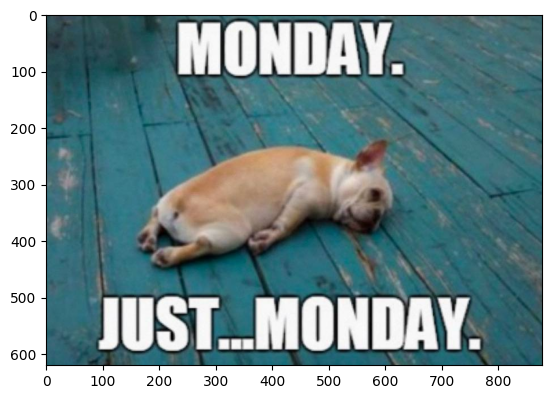

generated: This meme is funny because it is a play on words. The dog is saying "Monday" twice, which is a pun on the phrase "just Monday." The dog is also in a lazy position, which adds to the humor of the meme.


In [14]:
# Show the inference result.
plt.imshow(images[0])
plt.show()
print(f"generated: {sentence[0]}")